In [1]:
using Pkg; Pkg.activate(".")
using YAXArrays, Zarr
using OnlineStats: Mean, value, fit!, nobs
using YAXArrays.Cubes: cubesize, formatbytes

  Activating project at `/Net/Groups/BGI/people/fgans/DeepCube/FinalESDCDEmo`


In [ ]:
#Open the time series cube
ds = open_dataset("/Net/Groups/BGI/work_3/scratch/fgans/DeepCube/UC3Cube_rechunked2.zarr");

In [ ]:
#Select variables of interest
burned_area = ds.burned_areas;
preds = ("lst_night", "lst_day","dem", "lc_forest", "lc_grassland", "roads_distance")
possible_predictors = map(i->ds[Symbol(i)],preds);


In [ ]:
#Total uncompressed data size:
formatbytes(sum(cubesize,(burned_area,possible_predictors...)))

In [ ]:
indims_burnedarea = InDims(MovingWindow("x",3,3), MovingWindow("y",3,3), "Time", window_oob_value = 0.f0)
indims_predictors = map(possible_predictors) do p
    td = ndims(p) == 3 ? ("Time",) : ()
    InDims(MovingWindow("x",3,3), MovingWindow("y",3,3), td..., window_oob_value = 0.f0)
end

outdims = OutDims(
    Dim{:Variable}(collect(preds)), 
    outtype = Float32, 
    backend=:zarr,
    path = "./output.zarr", 
    overwrite=true
)


In [ ]:
n_workers = 20
threads_per_worker = 16
#Get 20 workers with 32 cpus per worker
using ClusterManagers: SlurmManager
using Distributed
map(1:20) do i
    Threads.@spawn begin
        addprocs(
            SlurmManager(1,fill(2.0,10)),
            partition="big",
            mem_per_cpu="16GB",
            time="00:30:00",
            cpus_per_task=16,
            exeflags=`--project=$(@__DIR__) -t 32 --heap-size-hint=8GB`
            )
    end
end

In [ ]:
#Load code everywhere
@everywhere begin
    using YAXArrays, Zarr
    using OnlineStats: Mean, value, fit!, nobs
    include("windowfire.jl")
    Zarr.Blosc.set_num_threads(16)
end

In [ ]:
mapCube(
    fire_boundaries_window!, 
    (burned_area, possible_predictors...);
    indims = (indims_burnedarea, indims_predictors...), 
    outdims = outdims,
    max_cache=2e9,
)

In [ ]:
rmprocs(workers())

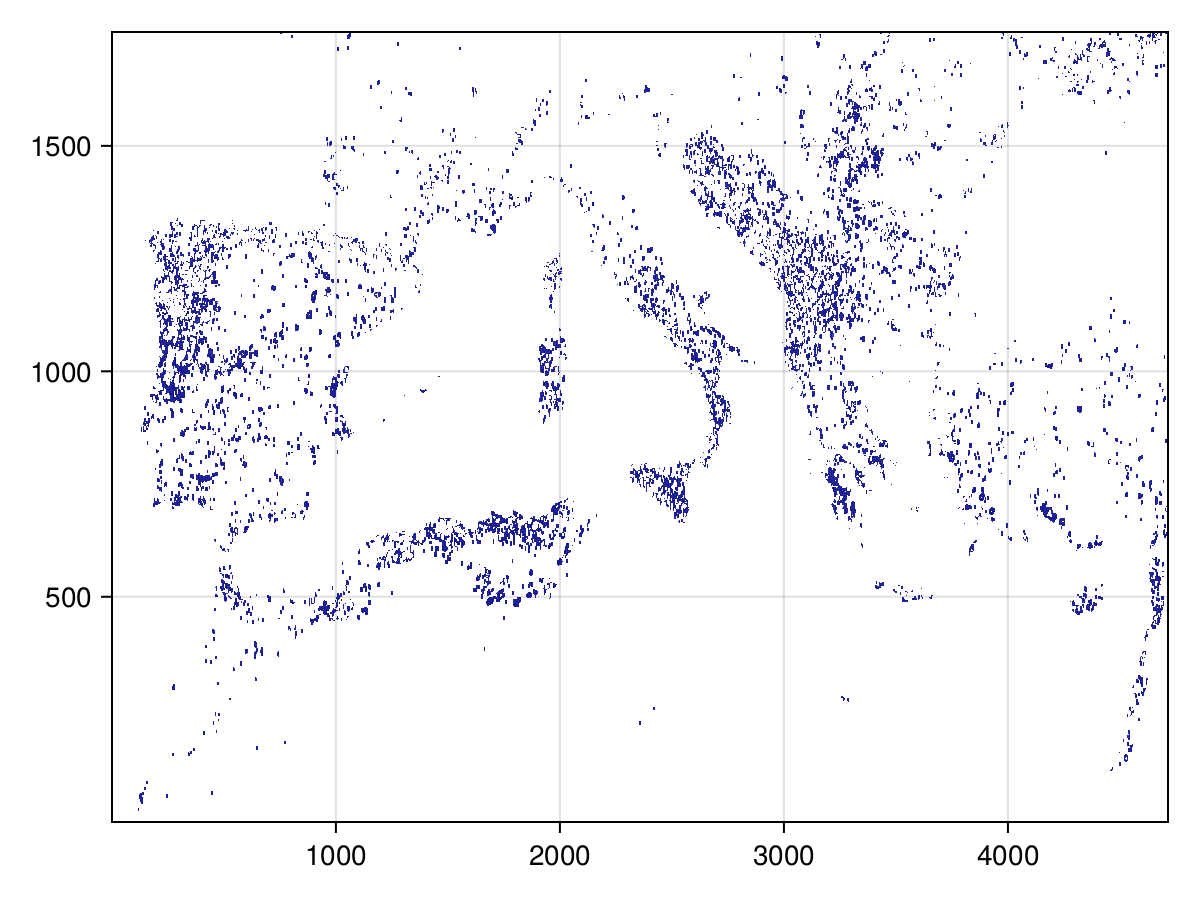

In [10]:
extrema(filter(i->!ismissing(i) && !isnan(i), data))

(-14.605673f0, 175.16486f0)

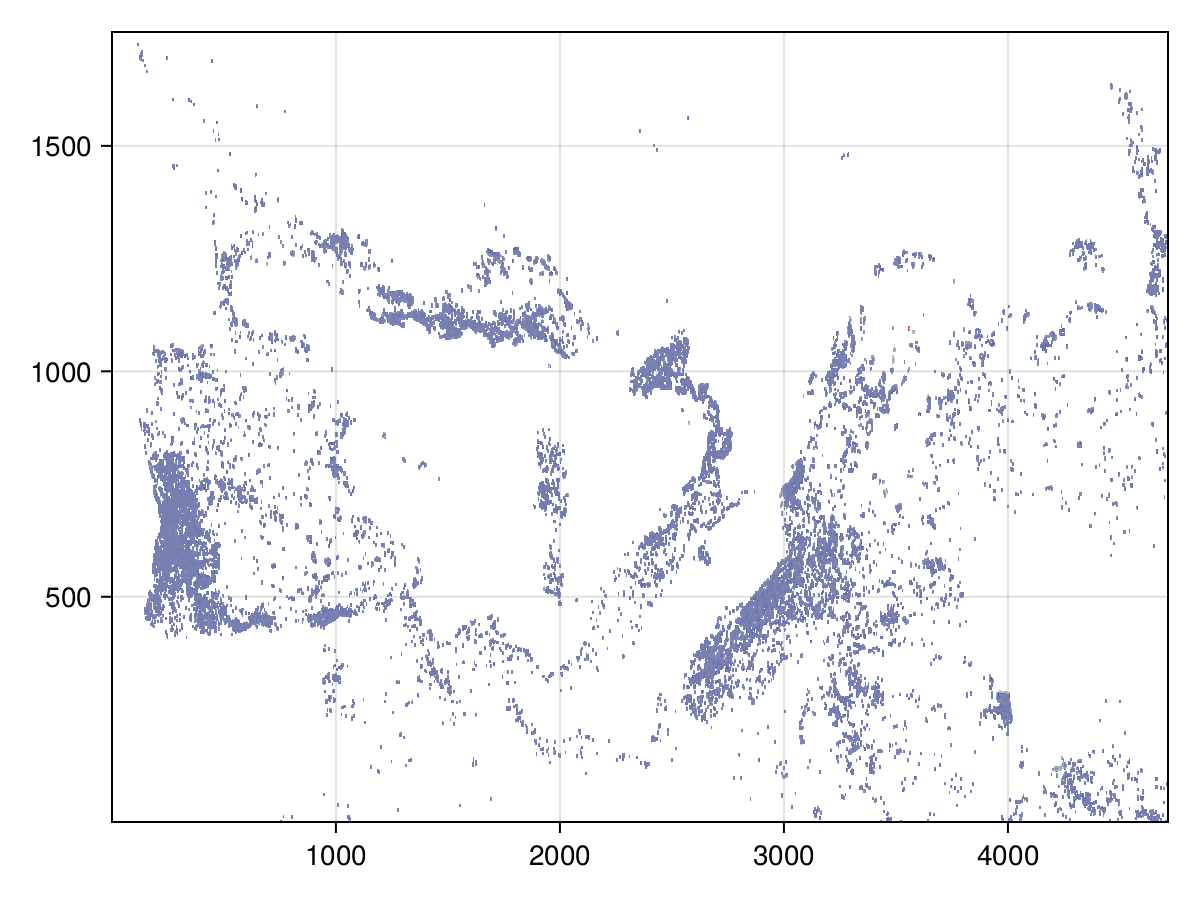

In [2]:
using CairoMakie, Makie, GeoMakie
using YAXArrays, Zarr
ds = open_dataset("output.zarr/")
heatmap(data,colormap=:bluesreds)
data  = reverse(ds.lst_day.data[:,:],dims=2)
heatmap(data,colormap=:bluesreds)